# Описание проекта

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.

В первой части проекта необходимо провести приоритезацию гипотез по увеличению выручки интернет-магазина, применив фреймфорки `ICE` и `RICE`.

Во второй части проекта нужно провести анализ проведенного A/B теста.

# Описание данных

**Данные для первой части.**

Файл `/datasets/hypothesis.csv`.

* Hypothesis — краткое описание гипотезы;
* Reach — охват пользователей по 10-балльной шкале;
* Impact — влияние на пользователей по 10-балльной шкале;
* Confidence — уверенность в гипотезе по 10-балльной шкале;
* Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

**Данные для второй части.**

Файл `/datasets/orders.csv`.

* transactionId — идентификатор заказа;
* visitorId — идентификатор пользователя, совершившего заказ;
* date — дата, когда был совершён заказ;
* revenue — выручка заказа;
* group — группа A/B-теста, в которую попал заказ.

Файл `/datasets/visitors.csv`.
* date — дата;
* group — группа A/B-теста;
* visitors — количество пользователей в указанную дату в указанной группе A/B-теста.

## Изучение общей информации

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

pd.set_option('display.max_colwidth', 1)

Прочитаем данные из файла `/datasets/hypothesis.csv`.

In [2]:
df_hypothesis = pd.read_csv('/datasets/hypothesis.csv')
df_hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Изучим инофрмацию этой таблицы.

In [3]:
df_hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


С данными все в порядке. Каждой переменной соответствует ее тип данных. Для удобства работы приведем названия столбцов к нижнему регистру.

In [4]:
df_hypothesis.columns = df_hypothesis.columns.str.lower()

Прочитаем данные из файла `/datasets/orders.csv`.

In [5]:
df_orders = pd.read_csv('/datasets/orders.csv')

Напишем фукнцию `def` для быстрого вывода определенной информации таблицы.

In [6]:
def inf(data: 'DataFrame'):
    print()
    print('Описание данных таблицы')
    print(data.info())
    print('====================================================================')
    print('Процент пропусков в таблице')
    print(data.isna().mean())
    print('====================================================================')
    print('Проверка на дубликаты')
    print(data.duplicated().sum())
    print('====================================================================')
    print('Визуальный осмотр данных таблицы')
    display(data.sample(5))

Применим функцию `def` к таблице `df_orders`.

In [7]:
inf(df_orders)


Описание данных таблицы
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None
Процент пропусков в таблице
transactionId    0.0
visitorId        0.0
date             0.0
revenue          0.0
group            0.0
dtype: float64
Проверка на дубликаты
0
Визуальный осмотр данных таблицы


,transactionId,visitorId,date,revenue,group
1013,83566152,232979603,2019-08-31,60,A
686,1573514293,3148168974,2019-08-29,5150,B
651,2782494067,4166660304,2019-08-07,90,B
441,2396420873,2171487014,2019-08-03,2955,B
1063,842507644,3170292896,2019-08-11,1190,B


Пропуски и дубликаты не найдены.

Для дальнейшей работы с этой таблицы необходимо изменить тип данных переменной `date` на `datetime64` и изменить названия первых двух переменных на более удобные.

Сначала изменим тип данных переменной `date`.

In [8]:
df_orders['date'] = pd.to_datetime(df_orders['date'])

Изменим названия первых двух столбцов.

In [9]:
df_orders = df_orders.rename(columns = {'transactionId' : 'transaction_id', 'visitorId' : 'visitor_id'})

Прочиатем данные из файла `/datasets/visitors.csv`.

In [10]:
df_visitors = pd.read_csv('/datasets/visitors.csv')

Применим функцию `def` к таблице `df_visitors`.

In [11]:
inf(df_visitors)


Описание данных таблицы
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None
Процент пропусков в таблице
date        0.0
group       0.0
visitors    0.0
dtype: float64
Проверка на дубликаты
0
Визуальный осмотр данных таблицы


,date,group,visitors
24,2019-08-25,A,621
53,2019-08-23,B,546
20,2019-08-21,A,646
28,2019-08-29,A,577
61,2019-08-31,B,718


Пропуски и дубликаты не найдены. Необходимо поменять тип данных переменной `date` на `datetime64`.

In [12]:
df_visitors['date'] = pd.to_datetime(df_visitors['date'])

### Вывод

В этом пункте проекта была произведена предобработка данных из трех предоставленных файлов, а именно:
* проверка на отсутствие пропусков и дубликатов;
* изменение типов данных на `datetime64` у перменных с датами;
* названия столбцов были изменены на более корректные.

## Приоритизация гипотез

### ICE

Применим фреймворк `ICE` для приоритизации гипотез.

Воспользуемся формулой:

$ICE = (Impact * Confidence) / Efforts$.

In [13]:
df_hypothesis['ice'] = df_hypothesis['impact'] * df_hypothesis['confidence'] / df_hypothesis['efforts']
df_hypothesis['ice'] = df_hypothesis['ice'].round(2)

Отсортируем значения `ICE` по убыванию и запищем результат в новую переменную. 

In [14]:
ice = df_hypothesis[['hypothesis', 'ice']].sort_values(by = 'ice', ascending = False)
ice

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Применив `ICE` выяснили, что гипотезы 8, 0 и 7 являются наиболее приоритетными.

### RICE

Теперь применим фреймворк `RICE`.
Воспользуемся формулой:

$ICE = (Reach * Impact * Confidence) / Efforts$.

In [15]:
df_hypothesis['rice'] = df_hypothesis['reach'] * df_hypothesis['ice']
df_hypothesis['rice'] = df_hypothesis['rice'].round(2)

Отсортируем значения `RICE` по убыванию и запищем результат в новую переменную. 

In [16]:
rice = df_hypothesis[['hypothesis', 'rice']].sort_values(by = 'rice', ascending = False)
rice

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",39.99
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8.96
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3.99
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.00


Добавив в учет охват пользователей ситуация изменилась.

### Вывод

Составим таблицу `ice_rice` для удобства сравнения методов приоретизации.

In [17]:
ice_rice = df_hypothesis[['hypothesis', 'rice', 'ice']].sort_values(by = 'rice', ascending = False)
ice_rice

,hypothesis,rice,ice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.00,11.20
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.00,7.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.00,8.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",39.99,13.33
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20,16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8.96,1.12
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.00,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3.99,1.33
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.00,1.00


Гипотеза 7 имеет максимальный рейтинг по Reach и поэтому по RICE она стала наиболее приоритетной гипотезой с большим отрывом по сравнению с остальными, хотя по ICE она была только на третьем месте по приоритетности, а гипотеза 8 имеет наименьший рейтинг по охвату пользователей, что поставило ее в середину списка приоритета.

Text(0.5, 0, 'RICE')

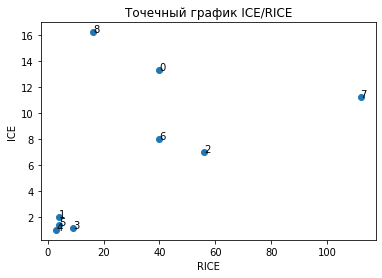

In [18]:
y = ice_rice['ice'].to_list()
z = ice_rice['rice'].to_list()
n = ice_rice.index.to_list()

fig, ax = plt.subplots()
ax.scatter(z, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]))

plt.title('Точечный график ICE/RICE')
plt.ylabel('ICE')
plt.xlabel('RICE')

## Анализ A/B-теста

### Кумулятивная выручка по группам

Для подсчета кумулятивной выручки по группам проделаем необходимые операции.

Сначала создадим массив уникальных пар значений дат и групп тестов.

In [19]:
dates_groups = df_orders[['date', 'group']].drop_duplicates()
dates_groups.head()

,date,group
0,2019-08-15,B
2,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A


Затем получим строки таблицы `df_orders`, где дата меньше или равна дате из таблицы `dates_groups` с помощью функции `np.logical_and`, а группа теста равна группе из `dates_groups`. Рассчитаем максимум для группы. Посчитаем количество уникальных заказов и пользователей. Осторстируем строки по дате и группе тестирования.

In [20]:
orders_aggregated = dates_groups.\
apply(lambda x: df_orders[np.logical_and(df_orders['date'] <= x['date'],
                                        df_orders['group'] == x['group'])].agg({'date' : 'max', 
                                                                                'group' : 'max', 
                                                                                'transaction_id' : pd.Series.nunique, 
                                                                                'visitor_id' : pd.Series.nunique, 
                                                                                'revenue' : 'sum'}), axis=1).\
sort_values(by=['date','group']).reset_index(drop = True)

orders_aggregated.head()

,date,group,transaction_id,visitor_id,revenue
0,2019-08-01,A,24,20,148579
1,2019-08-01,B,21,20,101217
2,2019-08-02,A,44,38,242401
3,2019-08-02,B,45,43,266748
4,2019-08-03,A,68,62,354874


После того, как получили агрегированные кумулятивные по дням данные по выручке, найдем агрегированные кумулятивные данные по дням о пользователях.

In [21]:
visitors_aggregated = dates_groups.\
apply(lambda x: df_visitors[np.logical_and(df_visitors['date'] <= x['date'], 
                                           df_visitors['group'] == x['group'])].agg({'date' : 'max', 
                                                                                     'group' : 'max', 
                                                                                    'visitors' : 'sum'}), axis=1).\
sort_values(by=['date','group']).reset_index(drop = True)

visitors_aggregated.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-01,B,713
2,2019-08-02,A,1338
3,2019-08-02,B,1294
4,2019-08-03,A,1845


Объеденим полученные таблицы по дате и группе тестирования и переименуем столбцы на более соответствующие.

In [22]:
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulative_data.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


Разделим полученну таблицу на две для каждой из групп.

In [23]:
cumulative_revenue_a = cumulative_data[cumulative_data['group'] == 'A'][['date', 'revenue', 'orders']]
cumulative_revenue_b = cumulative_data[cumulative_data['group'] == 'B'][['date', 'revenue', 'orders']]

Построим график кумулятивной выручки по дням и группам тестирования.

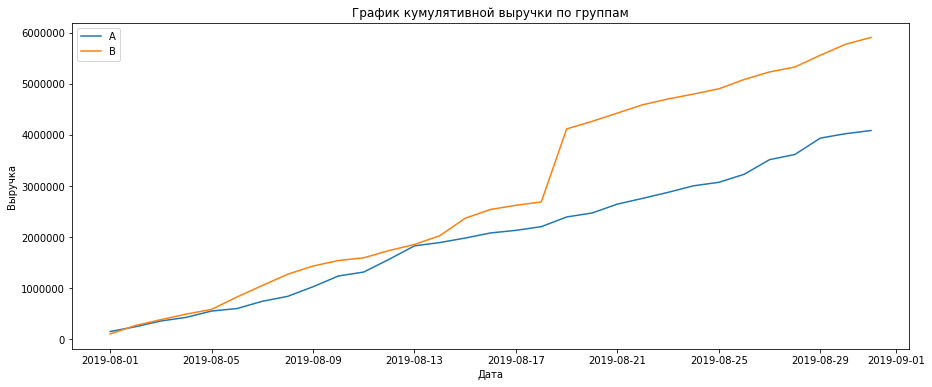

In [24]:
plt.figure(figsize=[15,6])

sns.lineplot(x = cumulative_revenue_a['date'], y = cumulative_revenue_a['revenue'], label = 'A')
sns.lineplot(x = cumulative_revenue_b['date'], y = cumulative_revenue_b['revenue'], label = 'B')
plt.title('График кумулятивной выручки по группам')
plt.ylabel('Выручка')
plt.xlabel('Дата')

plt.show()

Выручка каждой из групп стабильно растет вверх. Разве что график группы B в одной точке резко вырос вверх, что говорит об резком росте количестве заказов или появлении очень дорогих заказов в этом интервале времени.

### Кумулятивный средний чек по группам

Посмотрим на график среднего чека по группам. Чтобы найти средний чек нужно разделить кумулятивную выручку на кумулятивое количество пользователей.

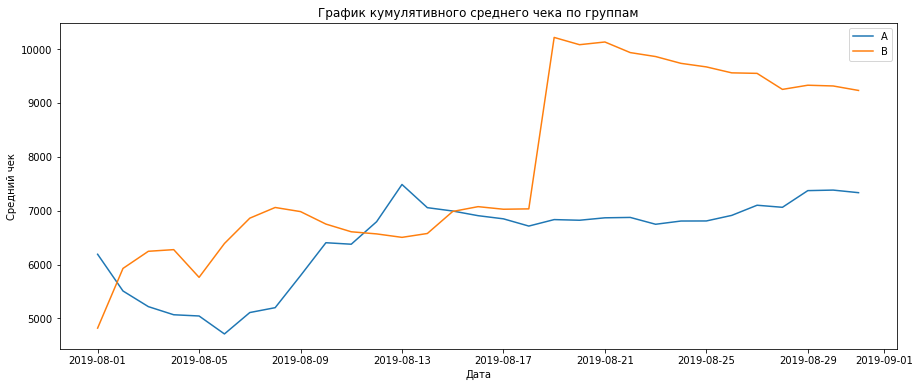

In [25]:
plt.figure(figsize=[15,6])

sns.lineplot(x = cumulative_revenue_a['date'], y = cumulative_revenue_a['revenue'] / cumulative_revenue_a['orders'], label = 'A')
sns.lineplot(x = cumulative_revenue_b['date'], y = cumulative_revenue_b['revenue'] / cumulative_revenue_b['orders'], label = 'B')
plt.title('График кумулятивного среднего чека по группам')
plt.ylabel('Средний чек')
plt.xlabel('Дата')

plt.show()


Ближе к концу теста средний чек группы А стабилизировался примерно на 7000, а средний чек группы В после резкого скачка постепенно идет на спад. Вероятно, что в середине теста в группе В были совершены дорогие заказы.

### Относительное изменения кумулятивного среднего чека группы B к группе A

Посмотрим на разницу в группах по среднему чеку более наглядней. Для этого построим график относительного различия между группами по среднему чеку.

Объеденим данные по группам в одной таблице.

In [26]:
merged_cumulative_revenue = cumulative_revenue_a.merge(cumulative_revenue_b,
                                                           left_on='date', 
                                                           right_on='date', 
                                                           how='left', 
                                                           suffixes=['A', 'B'])
merged_cumulative_revenue.head()

,date,revenueA,ordersA,revenueB,ordersB
0,2019-08-01,148579,24,101217,21
1,2019-08-02,242401,44,266748,45
2,2019-08-03,354874,68,380996,61
3,2019-08-04,425699,84,489567,78
4,2019-08-05,549917,109,581995,101


Построим график относительного различия.

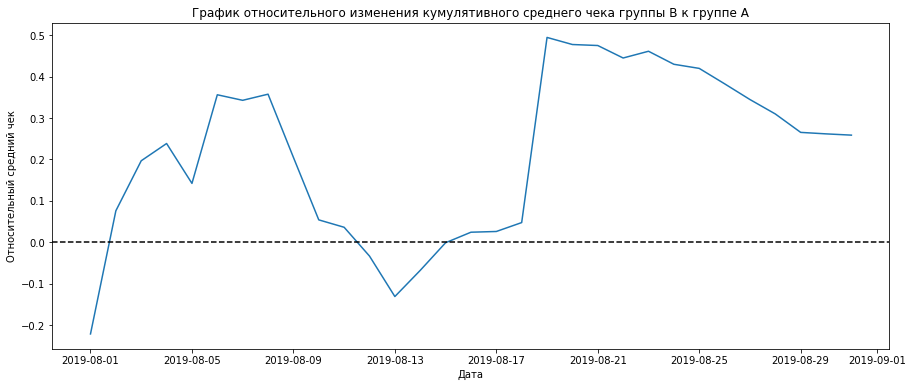

In [27]:
plt.figure(figsize=[15,6])

plt.plot(merged_cumulative_revenue['date'], 
        (merged_cumulative_revenue['revenueB']/merged_cumulative_revenue['ordersB'])/(merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['ordersA'])-1)

plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')

plt.xlabel('Дата')
plt.ylabel('Относительный средний чек')

plt.axhline(y=0, color='black', linestyle='--')

plt.show()

График характеризуется резкими скачками. На данном временном интервале большую часть времени лидирует группа В.

### Кумулятивная конверсия по группам

Посчитаем конверсию, разделим количество заказов на количество посетителей. Затем разделим таблицу на две по группам.

In [28]:
cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors']

cumulative_data_a = cumulative_data[cumulative_data['group'] == 'A']

cumulative_data_b = cumulative_data[cumulative_data['group'] == 'B']

Построим график кумулятивной конверсии по группам.

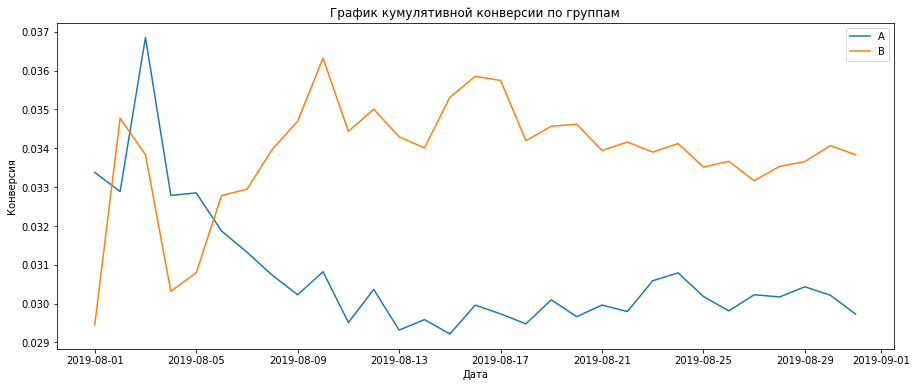

In [29]:
plt.figure(figsize=[15,6])

sns.lineplot(x = cumulative_data_a['date'], y = cumulative_data_a['conversion'], label = 'A')
sns.lineplot(x = cumulative_data_b['date'], y = cumulative_data_b['conversion'], label = 'B')
plt.title('График кумулятивной конверсии по группам')
plt.ylabel('Конверсия')
plt.xlabel('Дата')

plt.show()

После резких колебаний в обоих группах графики постепенно стабилизировались в значениях 0,034(B) и 0,030(А). Группа В опять показала себя лучше.

### Относительное изменение кумулятивной конверсии по группам

Объеденим таблицы с кумулятивными конверсиями.

In [30]:
merged_сummulative_сonversions = cumulative_data_a[['date','conversion']].merge(cumulative_data_b[['date','conversion']], 
                                                                                left_on='date', 
                                                                                right_on='date', 
                                                                                how='left', 
                                                                                suffixes=['A', 'B'])
merged_сummulative_сonversions.head()

,date,conversionA,conversionB
0,2019-08-01,0.033380,0.029453
1,2019-08-02,0.032885,0.034776
2,2019-08-03,0.036856,0.033833
3,2019-08-04,0.032787,0.030315
4,2019-08-05,0.032851,0.030793


Построим график относительного изменения кумулятивной конверсии.

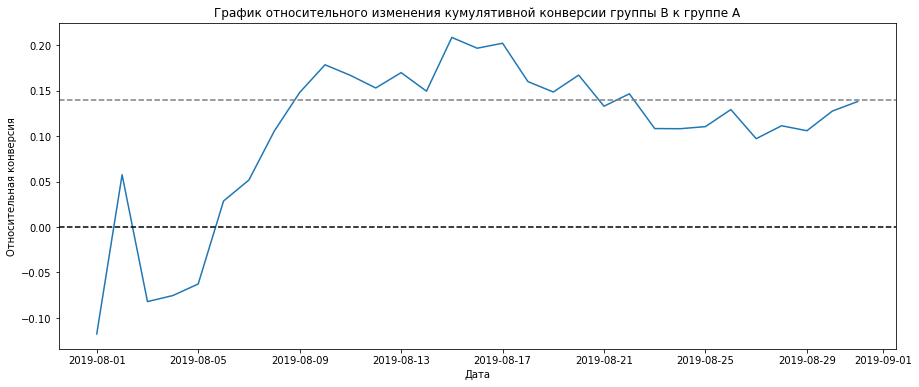

In [31]:
plt.figure(figsize=[15,6])

plt.plot(merged_сummulative_сonversions['date'], 
        (merged_сummulative_сonversions['conversionB']/merged_сummulative_сonversions['conversionA'])-1)

plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')

plt.xlabel('Дата')
plt.ylabel('Относительная конверсия')

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.14, color='grey', linestyle='--')

plt.show()

Практически с самого начала лидирует группа В по конверсии. В конце теста значение конверсии группы В лучше на 14%, чем значение конверсии группы А.

### Анализ аномальных значений количества заказов по пользователям

Найдем число заказов по пользователям.

In [32]:
orders_by_users = (
    df_orders.drop(['group', 'revenue', 'date'], axis=1)
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)

orders_by_users.columns = ['visitor_id', 'orders']

orders_by_users.sort_values(by='orders',ascending=False).head(5)

,visitor_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5


Построим точечный график количества заказов по пользователям.

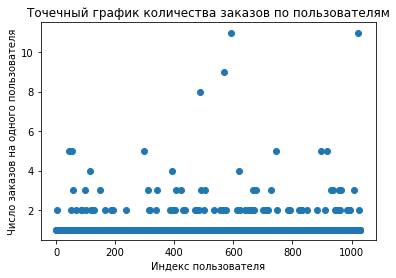

In [33]:
x_values = pd.Series(range(0, len(orders_by_users)))

plt.scatter(x_values, orders_by_users['orders'])

plt.title('Точечный график количества заказов по пользователям')
plt.ylabel('Число заказов на одного пользователя')
plt.xlabel('Индекс пользователя')

plt.show()

In [34]:
orders_by_users_ad = (
    df_orders.drop(['revenue', 'date'], axis=1)
    .groupby(['visitor_id', 'group'], as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)


orders_by_users_ad_a = orders_by_users_ad[orders_by_users_ad['group'] == 'A'].drop('group', axis = 1)
orders_by_users_ad_b = orders_by_users_ad[orders_by_users_ad['group'] == 'B'].drop('group', axis = 1)

orders_by_users_ad_a.columns = ['visitor_id', 'orders']
orders_by_users_ad_b.columns = ['visitor_id', 'orders']

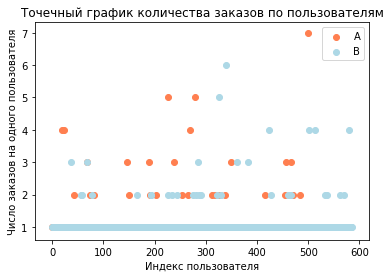

In [35]:
x_values_a = pd.Series(range(0, len(orders_by_users_ad_a)))

plt.scatter(x_values_a, orders_by_users_ad_a['orders'], c = 'coral', label = 'A')

x_values_b = pd.Series(range(0, len(orders_by_users_ad_b)))

plt.scatter(x_values_b, orders_by_users_ad_b['orders'], c = 'lightblue', label = 'B')

plt.legend()

plt.title('Точечный график количества заказов по пользователям')
plt.ylabel('Число заказов на одного пользователя')
plt.xlabel('Индекс пользователя')

plt.show()

Пользователей, заказавших более двух раз не так много. Чтобы узнать точно аномальные значения посчитаем перцентили.

In [36]:
np.percentile(orders_by_users['orders'], [95, 99])

array([2., 4.])

Только 1% процент пользователей совершали более 4-х заказов и 5% процентов пользователей заказывали больше 2-х заказов. Определим 2 заказа на одного пользователя за нижнюю границу числа заказов.

### Анализ аномальных значений стоимостей заказов

Построим точечный график стоимостей заказов.

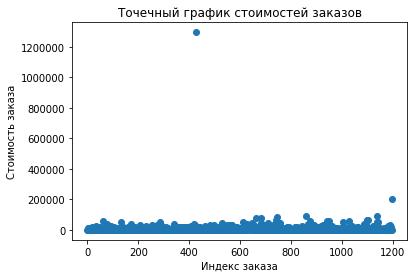

In [37]:
x_values = pd.Series(range(0, len(df_orders['revenue'])))

plt.scatter(x_values, df_orders['revenue'])

plt.title('Точечный график стоимостей заказов')
plt.ylabel('Стоимость заказа')
plt.xlabel('Индекс заказа')

plt.show()

<Figure size 432x360 with 0 Axes>

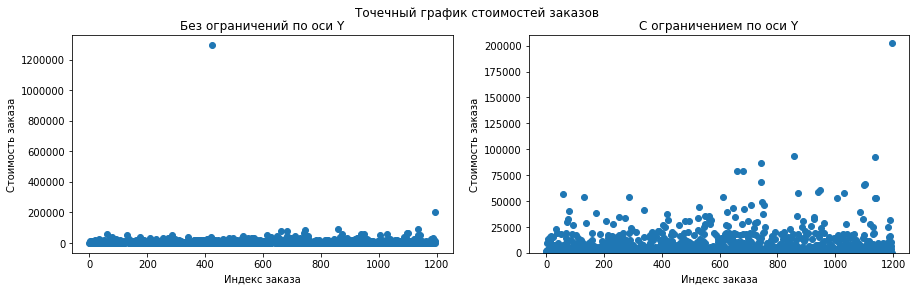

In [38]:
x_values = pd.Series(range(0, len(df_orders['revenue'])))

plt.figure().set_figheight(5)
plt.figure().set_figwidth(15)

plt.subplot(1, 2, 1)
plt.scatter(x_values, df_orders['revenue'])
plt.title('Без ограничений по оси Y')
plt.ylabel('Стоимость заказа')
plt.xlabel('Индекс заказа')

plt.subplot(1, 2, 2)
plt.scatter(x_values, df_orders['revenue'])
plt.ylim([0, 210000])
plt.title('С ограничением по оси Y')
plt.ylabel('Стоимость заказа')
plt.xlabel('Индекс заказа')

plt.suptitle('Точечный график стоимостей заказов')
plt.show()

Все заказы в пределах стоимости около 100000 кроме одного, стоимость которого более 1200000. Именно этот заказ создавал резкие скачки на предыдущих графиках. 

Посчитаем перцентили.

In [39]:
np.percentile(df_orders['revenue'], [95, 99])

array([28000. , 58233.2])

Только 5% процетнов пользователей совершали заказ на более 28000. Примем этот показатель за нижнюю границу стоимости заказа.

### Cтатистическая значимость различий в конверсии и в среднем чеке заказа между группами по «сырым» данным

Посчитаем количество пользователей в выбранную дату `visitors_per_date` и количество пользователей до выбранной даты включительно `visitors_cummulative` для каждой из групп.

In [40]:
visitors_a_daily = df_visitors[df_visitors['group']=='A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_date_a']

visitors_a_cummulative = visitors_a_daily.apply(lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']]\
                                                .agg({'date' : 'max', 'visitors_per_date_a' : 'sum'}), axis=1)
visitors_a_cummulative.columns = ['date', 'visitors_cummulative_a']

visitors_b_daily = df_visitors[df_visitors['group']=='B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date_b']

visitors_b_cummulative = visitors_b_daily.apply(lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']]\
                                                .agg({'date' : 'max', 'visitors_per_date_b' : 'sum'}), axis=1)
visitors_b_cummulative.columns = ['date', 'visitors_cummulative_b']

Посчитаем количество заказов в выбранную дату `orders_per_date` и суммарное количество заказов до выбранной даты включительно `orders_cummulative`, суммарную выручку в выбранную дату `revenue_per_date` и суммарную выручку до выбранной даты включительно `revenue_cummulative` для каждой из групп.

In [41]:
orders_a_daily = (
    df_orders[df_orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_a_daily.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']

orders_a_cummulative = orders_a_daily.apply(
    lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_a': 'sum', 'revenue_per_date_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_a_cummulative.columns = ['date', 'orders_cummulative_a', 'revenue_cummulative_a']

orders_b_daily = (
    df_orders[df_orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_b_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

orders_b_cummulative = orders_b_daily.apply(
    lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_b': 'sum', 'revenue_per_date_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_b_cummulative.columns = ['date', 'orders_cummulative_b', 'revenue_cummulative_b']

Объеденим все полученные значения в одну таблицу `data`.

In [42]:
data = (
    orders_a_daily.merge(
        orders_b_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_b_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cummulative, left_on='date', right_on='date', how='left')
)

data.head()

,date,orders_per_date_a,revenue_per_date_a,orders_per_date_b,revenue_per_date_b,orders_cummulative_a,revenue_cummulative_a,orders_cummulative_b,revenue_cummulative_b,visitors_per_date_a,visitors_per_date_b,visitors_cummulative_a,visitors_cummulative_b
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Создадим таблицы, где для пользователей, совершивших хотя бы один заказ, будет указано число заказов.

In [43]:
orders_by_users_a = (
    df_orders[df_orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_a.columns = ['visitor_id', 'orders']

orders_by_users_b = (
    df_orders[df_orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_b.columns = ['visitor_id', 'orders']

Создадим переменные `sample_a` и `sample_b`, в которых пользователям с заказами будет соответствовать число заказов пользователя, а пользователям без заказов — нули.

In [44]:
sample_a = pd.concat([orders_by_users_a['orders'], 
                      pd.Series(0, 
                                index=np.arange(data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])), 
                                name='orders')], axis=0)

sample_b = pd.concat([orders_by_users_b['orders'], 
                      pd.Series(0, 
                                index=np.arange(data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])), 
                                name='orders')], axis=0)

С помощью теста Манна-Уитни посчитаем статистическую значимость различия конверсии.

**Нулевая гипотеза:** конверсии в группах А и В по "сырым" данным не отличаются.
    
**Альтернативная гипотеза:** конверсии в группах А и В по "сырым" данным отличаются.
    
**Уровень статистической зачимости:** 5%.


In [45]:
print('p-value: {0:.3f}'.format(st.mannwhitneyu(sample_a, sample_b, alternative = 'two-sided')[1]))
print('Относительное различие в конверсии между группами: {0:.3f}'.format(sample_b.mean()/sample_a.mean()-1))

p-value: 0.017
Относительное различие в конверсии между группами: 0.138


Значение p-value значительно меньше 0.05, поэтому отвергаем нулевую гипотезу. Значит статистических значимых различия в конверсии между группами присутствуют. Относительный выйгрыш группы В равен 13.8%.

Посчитаем статистическую значимость различия средних чеков между группами.

**Нулевая гипотеза:** средний чек в группах А и В по "сырым" данным не отличается.
    
**Альтернативная гипотеза:** средний чек в группах А и В по "сырым" данным отличается.
    
**Уровень статистической зачимости:** 5%.

In [46]:
print('p-value: {0:.3f}'.format(st.mannwhitneyu(df_orders[df_orders['group']=='A']['revenue'], df_orders[df_orders['group']=='B']['revenue'], alternative = 'two-sided')[1]))
print('Относительное различие в среднем чеке между группами: {0:.3f}'.format(df_orders[df_orders['group']=='B']['revenue'].mean()/df_orders[df_orders['group']=='A']['revenue'].mean()-1)) 

p-value: 0.729
Относительное различие в среднем чеке между группами: 0.259


Значение p-value значительно больше 0.05, поэтому мы не можем отвергнуть нулевую гипотезу, хотя средний чек группы В больше на 25.9%.

### Cтатистическая значимость различий в конверсии и в среднем чеке заказа между группами по «очищенным» данным

Для начала сделаем срезы по выбранным границам. Мы приняли, что аномальное количество заказов начинается от 2, а стоимость от 28000. Найдем всех пользователей с аномальными значениями.

In [47]:
users_wth_many_orders = pd.concat(
    [orders_by_users_a[orders_by_users_a['orders'] > 2]['visitor_id'], 
     orders_by_users_b[orders_by_users_b['orders'] > 2]['visitor_id']], axis=0)

users_with_expensive_orders = df_orders[df_orders['revenue'] > 28000]['visitor_id']

abnormal_users = pd.concat([users_wth_many_orders, users_with_expensive_orders], axis=0).drop_duplicates().sort_values()

abnormal_users

1099    148427295 
18      199603092 
928     204675465 
23      237748145 
37      249864742 
          ...     
723     4009017467
627     4120364173
743     4133034833
499     4256040402
662     4266935830
Name: visitor_id, Length: 74, dtype: int64

Таких пользователей оказалось 74.

Создадим переменные `sample_a_filtered` и `sample_b_filtered`, в которых сохраним очищенные данные о заказах — не включая аномальных пользователей.

In [48]:
sample_a_filtered = pd.concat([orders_by_users_a[np.logical_not(orders_by_users_a['visitor_id'].isin(abnormal_users))]['orders'],
                             pd.Series(0, index=np.arange(data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])),
                                       name='orders')],axis=0)

sample_b_filtered = pd.concat([orders_by_users_b[np.logical_not(orders_by_users_b['visitor_id'].isin(abnormal_users))]['orders'],
                             pd.Series(0, index=np.arange(data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])),
                                       name='orders')],axis=0)

С помощью теста Манна-Уитни посчитаем статистическую значимость различия конверсии.

**Нулевая гипотеза:** конверсии в группах А и В по "очищенным" данным не отличаются.
    
**Альтернативная гипотеза:** конверсии в группах А и В по "очищенным" данным отличаются.
    
**Уровень статистической зачимости:** 5%.

In [49]:
print('p-value: {0:.3f}'.format(st.mannwhitneyu(sample_a_filtered, sample_b_filtered, alternative = 'two-sided')[1]))
print('Относительное различие в конверсии между группами: {0:.3f}'.format(sample_b_filtered.mean()/sample_a_filtered.mean()-1)) 

p-value: 0.013
Относительное различие в конверсии между группами: 0.173


Значение p-value значительно меньше 0.05, поэтому отвергаем нулевую гипотезу. Значит статистических значимых различия в конверсии между группами присутствуют. Относительный выйгрыш группы В увеличился с 13.8% до 17.3%.

Посчитаем статистическую значимость различия средних чеков между группами.

**Нулевая гипотеза:** средний чек в группах А и В по "очищенным" данным не отличается.
    
**Альтернативная гипотеза:** средний чек в группах А и В по "очищенным" данным отличается.
    
**Уровень статистической зачимости:** 5%.

In [50]:
print('p-value: {0:.3f}'.format(st.mannwhitneyu(df_orders[np.logical_and(df_orders['group'] == 'A',
                                                                np.logical_not(df_orders['visitor_id'].isin(abnormal_users)))]\
                                                ['revenue'], df_orders[np.logical_and(df_orders['group'] == 'B',
                                                                np.logical_not(df_orders['visitor_id'].isin(abnormal_users)))]\
                                                ['revenue'], alternative = 'two-sided')[1]))

print('Относительное различие в среднем чеке между группами: {0:.3f}'.format(df_orders[np.logical_and(df_orders['group'] == 'B',
                np.logical_not(df_orders['visitor_id'].isin(abnormal_users)))]['revenue'].mean() / df_orders[np.logical_and(
                df_orders['group'] == 'A',
                np.logical_not(df_orders['visitor_id'].isin(abnormal_users)))]['revenue'].mean() - 1))

p-value: 0.738
Относительное различие в среднем чеке между группами: -0.020


Значение p-value значительно больше 0.05, поэтому мы не можем отвергнуть нулевую гипотезу. Средний чек группы В стал меньше, чем средний чек в группе А на 2%.

### Вывод

* Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий.
* Нет статистически значимых различий по среднему чеку между группами как по сырым данным, так и после фильтрации аномалий.
* График различия конверсии между группами сообщает, что результаты группы B лучше группы A: имеют тенденцию к росту, либо зафиксировались около среднего значения равное около 0.14.
* График различия среднего чека колеблется. Сделать из этого графика определённые выводы нельзя.


Исходя из этого можно принять решение об остановке теста и объявить его успешным. Анализ теста показал, что группа В является более успешной. Конверсия в группе В больше на 17%, чем в группе А.